<a href="https://colab.research.google.com/github/EAkeweje/Accelerating-Hydrogen-Oxidation-Calculations/blob/main/Main_ModelTrainingInference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import PIL
import pandas as pd
from tqdm.notebook import tqdm
import json
import time
import cv2
import random
import glob
import os
import copy
from sklearn.metrics import r2_score

## Utils

In [3]:
#Dataset object
class OxidationDataset(Dataset):

  def __init__(self, inputs_path, outputs_dir, nsample, ntimesteps, exclude_h2_o2 = False, return_conc = False):
    """
    Args:
        inputs_dir (string): input data path
        outputs_dir (string): output data directory
        nsample (int): data size
        ntimesteps (int, list, or string): number of timesteps in target
        exclude_h2_o2 (bool): To remove H2 and O2 features (from input and output)
        return_conc (bool): To activate conversion of model inputs to concentrations, rather than proportions
    returns:
        Input data tensor
        Output data tensor 
    """
    
    # x = np.loadtxt(inputs_path, skiprows = 1, delimiter= ',')
    # x = np.loadtxt(inputs_path, delimiter= ' ')
    with open(inputs_path, 'rb') as f:
      x = np.load(f)
    self.exclude = exclude_h2_o2
    #drop inert gases
    if not self.exclude:
      self.props = np.delete(x[ :nsample, :], [8,9], 1)
    else:
      self.props = np.delete(x[ :nsample, :], [0, 3, 8, 9], 1)
    self.out_dir = outputs_dir
    self.ntimesteps = ntimesteps
    self.return_conc = return_conc

  def get_total_material(self, Pressure, Temperature):
    R = 8.31441642554361
    return Pressure / (R * Temperature)

  def __len__(self):
    return len(self.props)

  def __getitem__(self, idx):
    #process input
    if self.return_conc:
      #get pressure and temperature
      pres = self.props[idx, -2]
      temp = self.props[idx, -1]
      #compute total amount of all gases
      total_amount_all = self.get_total_material(pres, temp)
      #compute concentrations
      concs = self.props[idx,:-2]*total_amount_all #c_i = x_i * \nu
      input = np.concatenate((concs, self.props[idx,-2:]))
    else:
      input = self.props[idx]
    #get output
    # Y = np.loadtxt(os.path.join(self.out_dir, f'out{idx}.txt'), delimiter= ';')
    with open(os.path.join(self.out_dir, f'out{idx}.npy'), 'rb') as f:
      Y = np.load(f)

    #drop inert gases
    if type(self.ntimesteps) == int:
      if self.return_conc:
        assert self.ntimesteps != 0, 'Ensure the target time step is different from zeroth timestep'
      target = Y[:self.ntimesteps, 1:-2]
    elif type(self.ntimesteps) == list:
      if self.return_conc:
        assert self.ntimesteps not in self.ntimesteps, 'Ensure the target time steps do not include the zeroth timestep'
      target = Y[self.ntimesteps, 1:-2]
    elif self.ntimesteps == 'all':
      if self.return_conc:
        target = Y[1:, 1:-2]
      else:
        target = Y[1:, 1:-2]
    else:
        raise ValueError("Invalid argument 'ntimestep' should an interger, a list or 'all' string")

    if self.exclude:
      target = np.delete(target, [1,4], axis = 1)

    return torch.from_numpy(input[np.newaxis,:]), torch.from_numpy(target)

In [4]:
#for data standardization
def standardize(tensor, dim = 0, mean = None, std = None) -> torch.float64:
    tensor = tensor.float()

    if mean is None:
        mean = tensor.mean(dim = dim, keepdim = True)

    if std is None:
        std = tensor.std(dim = dim, keepdim = True)

    standard_tensor = (tensor - mean) / std
    return standard_tensor, mean, std

def inverse_standardize(tensor, dim, mean, std):
    tensor = tensor.float()
    return tensor * std + mean

In [5]:
def load_mean_std(path, loader = None):
  if os.path.exists(path):
    #get means and stds
    with open(path, 'r') as f:
        mean_std_dict = json.load(f)
    train_x_mean = torch.tensor(mean_std_dict['mean_x'])
    train_x_std = torch.tensor(mean_std_dict['std_x'])
    train_y_mean = torch.tensor(mean_std_dict['mean_y'])
    train_y_std = torch.tensor(mean_std_dict['std_y'])
    return train_x_mean, train_x_std, train_y_mean, train_y_std
  else:
    return save_mean_std(loader, path, output = True)
  

In [6]:
def save_mean_std(loader, path, output = False):
  '''
  Args:
    loader: preferably train loader
    path: a json path
    output (bool) : to return the means and stds
  '''
  #obtaining mean and std of training set
  train_x = []
  train_y = []
  for x,y in loader:
      train_x.append(x)
      train_y.append(y)

  _, train_x_mean, train_x_std = standardize(torch.concat(train_x), 0)
  _, train_y_mean, train_y_std = standardize(torch.concat(train_y), 0)

  #write to disc
  mean_std_dict = {
      'mean_x' : train_x_mean.tolist(),
      'mean_y' : train_y_mean.tolist(),
      'std_x' : train_x_std.tolist(),
      'std_y' : train_y_std.tolist()
  }

  with open(path, 'w') as f:
    json.dump(mean_std_dict, f)
  
  if output:
    return train_x_mean, train_x_std, train_y_mean, train_y_std

In [7]:
###Networks
#single step
class RNN_Model(nn.Module):
    def __init__(self, config):
        super(RNN_Model, self).__init__()
        self.input_size = config['input_size']
        self.hidden_size = config['hidden_size']
        self.output_size = config['output_size']
        self.num_layers = config['num_layers']
        self.rnn = nn.RNN(self.input_size, self.hidden_size, self.num_layers, dropout = 0.1, batch_first = True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.linear(out)
        return out
    
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_uniform_(m.weight, nonlinearity= 'relu')
        m.bias.data.fill_(0.0)

###multiple time steps
#one to many RNN architechture
class Base_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Base_RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(self.input_size, self.hidden_size, self.num_layers, dropout = 0.1, batch_first = True)
        self.linear = nn.Linear(self.hidden_size, self.input_size)
        
    def forward(self, x, in_hidden = None):
        if in_hidden == None:
            out, out_hidden = self.rnn(x)
        else:
            out, out_hidden = self.rnn(x, in_hidden)
        out = self.linear(out)
        return out, out_hidden

class RNN_Model_Multiple(nn.Module):
    def __init__(self, config):
        super(RNN_Model_Multiple, self).__init__()
        self.input_size = config['input_size']
        self.hidden_size = config['hidden_size']
        self.output_size = config['output_size']
        self.num_layers = config['num_layers']
        self.ntimesteps = config['ntimesteps']
        self.base_rnn = Base_RNN(self.input_size, self.hidden_size, self.num_layers)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(self.input_size, self.output_size)
        
    def forward(self, x):
        out = x
        hidden = None
        
        #to store outputs
        outputs = []
        
        for t in range(self.ntimesteps):                
            #pass to rnn
            out, hidden = self.base_rnn(out, hidden)
            #pass to output layer
            outputs.append(self.linear(self.relu(out)))
            #skip connection
            out += x

        return torch.concat(outputs, 1)

#one to many RNN architechture
class Base_RNN_v2(nn.Module):
    def __init__(self, output_size, hidden_size, num_layers):
        super(Base_RNN_v2, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(self.output_size, self.hidden_size, self.num_layers, dropout = 0.1, batch_first = True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x, in_hidden = None):
        if in_hidden == None:
            out, out_hidden = self.rnn(x)
        else:
            out, out_hidden = self.rnn(x, in_hidden)
        out = self.linear(out)
        return out, out_hidden

class RNN_Model_Multiple_v2(nn.Module):
    def __init__(self, config):
        super(RNN_Model_Multiple_v2, self).__init__()
        self.input_size = config['input_size']
        self.hidden_size = config['hidden_size']
        self.output_size = config['output_size']
        self.num_layers = config['num_layers']
        self.ntimesteps = config['ntimesteps']
        self.base_rnn = Base_RNN_v2(self.output_size, self.hidden_size, self.num_layers)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(self.input_size, self.output_size)

    def forward(self, x):
        #pass to first layer and activation
        x = self.relu(self.linear(x))

        #to store outputs
        outputs = []

        #set inputs to first RNN layer
        out = x
        hidden = None

        #loop through rnn layers
        for t in range(self.ntimesteps):                
            #pass to rnn
            out, hidden = self.base_rnn(out, hidden)
            #pass to output layer
            outputs.append(out)
            #skip connection
            out += x

        return torch.concat(outputs, 1)

In [8]:
def make_dataloaders(config):
    '''
    batch_size: int = batch size
    ntimesteps: int or list = number/list of time steps in data
    nsample: int = number of samples to use
    split: list = list of train set to data ration and train+valid set to data ratio
    '''
    #initialize dataset object
    dataset = OxidationDataset(inputs_path = 'input_98660.npy',
                               outputs_dir = './Out_files_npy',
                               nsample = config['nsample'],
                               ntimesteps = config['timesteps'],
                               exclude_h2_o2 = config['exclude'],
                               return_conc= config['return_conc'])
    # Creating Training, Validation, and Test dataloaders
    # split Train : Val : Test = 0.7 : 0.2 : 0.1
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    train_split = int(np.floor(config['split'][0] * dataset_size))
    val_split = int(np.floor(config['split'][1] * dataset_size))
    shuffle_dataset = True
    random_seed = 42
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices = indices[ : train_split]
    val_indices = indices[train_split : train_split + val_split]
    test_indices = indices[train_split + val_split : ]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = DataLoader(dataset, batch_size = config['batch_size'], sampler=train_sampler)
    validation_loader = DataLoader(dataset, batch_size = config['batch_size'], sampler=valid_sampler)
    test_loader = DataLoader(dataset, batch_size = config['batch_size'], sampler=test_sampler)
    
    return train_loader, validation_loader, test_loader

def to_device(model, train_x_mean, train_x_std, train_y_mean, train_y_std):
  if torch.cuda.is_available():
    model = model.cuda()
    train_x_mean = train_x_mean.cuda()
    train_x_std = train_x_std.cuda()
    train_y_mean = train_y_mean.cuda()
    train_y_std = train_y_std.cuda()

In [9]:
def total_material(y_true, y_pred):
  '''
  Computes the total material (moles) of Hydrogen and Oxygen in product.
  y_true: ground truth
  y_pred: (model) prediction
  '''
  assert y_true.ndim == y_pred.ndim, f'Tensors are of different dimensions: {y_true.ndim} and {y_pred.ndim}'
  assert y_true.shape == y_pred.shape, f'Shape of tensor are different: {y_true.shape} and {y_pred.shape}'
  assert y_true.ndim < 4, f'Tensor dimension must be less than 4: {y_true.ndim}'

  if y_true.ndim == 1:
    T_H_true = 2*y_true[1] + y_true[2] + y_true[5]+ 2*y_true[6] + y_true[7]+ 2*y_true[8]
    T_H_pred = 2*y_pred[1] + y_pred[2] + y_pred[5]+ 2*y_pred[6] + y_pred[7]+ 2*y_pred[8]
    T_O_true = y_true[3] + 2*y_true[4] + y_true[5]+ y_true[6] + 2*y_true[7]+ 2*y_true[8]
    T_O_pred = y_pred[3] + 2*y_pred[4] + y_pred[5]+ y_pred[6] + 2*y_pred[7]+ 2*y_pred[8]

  elif y_true.ndim == 2:
    T_H_true = 2*y_true[:,1] + y_true[:,2] + y_true[:,5]+ 2*y_true[:,6] + y_true[:,7]+ 2*y_true[:,8]
    T_H_pred = 2*y_pred[:,1] + y_pred[:,2] + y_pred[:,5]+ 2*y_pred[:,6] + y_pred[:,7]+ 2*y_pred[:,8]
    T_O_true = y_true[:,3] + 2*y_true[:,4] + y_true[:,5]+ y_true[:,6] + 2*y_true[:,7]+ 2*y_true[:,8]
    T_O_pred = y_pred[:,3] + 2*y_pred[:,4] + y_pred[:,5]+ y_pred[:,6] + 2*y_pred[:,7]+ 2*y_pred[:,8]
  
  elif y_true.ndim == 3:
    T_H_true = 2*y_true[:,:,1] + y_true[:,:,2] + y_true[:,:,5]+ 2*y_true[:,:,6] + y_true[:,:,7]+ 2*y_true[:,:,8]
    T_H_pred = 2*y_pred[:,:,1] + y_pred[:,:,2] + y_pred[:,:,5]+ 2*y_pred[:,:,6] + y_pred[:,:,7]+ 2*y_pred[:,:,8]
    T_O_true = y_true[:,:,3] + 2*y_true[:,:,4] + y_true[:,:,5]+ y_true[:,:,6] + 2*y_true[:,:,7]+ 2*y_true[:,:,8]
    T_O_pred = y_pred[:,:,3] + 2*y_pred[:,:,4] + y_pred[:,:,5]+ y_pred[:,:,6] + 2*y_pred[:,:,7]+ 2*y_pred[:,:,8]
  
  return T_H_true, T_H_pred, T_O_true, T_O_pred


In [10]:
def train_step(model, optimizer, criterion, dataloader, mean_std, device, mb_coeff = 0):
  '''
  Do one training epoch.
  mb_coeff is material balance weight. If mb_coeff == 0, then material balance is not considered.
  '''
  train_loss_ = 0.0
  model.train()
  for input, target in dataloader:
    # Transfer Data to GPU if available
    input, target = input.to(device), target.to(device)
    # Standardize
    if mean_std:
      input, _, _ = standardize(input, 0, mean_std[0], mean_std[1])
      target, _, _ = standardize(target, 0, mean_std[2], mean_std[3])
    # Forward Pass
    predict = model(input.float())
    # Find loss
    if mb_coeff != 0:
      #Material Balance
      T_H_true, T_H_pred, T_O_true, T_O_pred = total_material(target, predict)
      loss = criterion(predict,target.float()) + mb_coeff * criterion(T_H_pred, T_H_true) + mb_coeff * criterion(T_O_pred, T_O_true)
    else:
      loss = criterion(predict, target.float())
    # Clear the gradients
    optimizer.zero_grad()
    # Calculate gradients
    loss.backward()
    # Update Weights
    optimizer.step()
    # Calculate Loss
    train_loss_ += loss.item() 
  return train_loss_

def valid_step(model, criterion, dataloader, mean_std, device, mb_coeff = 0):
  valid_loss_ = 0.0
  model.eval()     # Optional when not using Model Specific layer
  for input, target in dataloader:
    # Transfer Data to GPU if available
    input, target = input.to(device), target.to(device)
    #standardize
    if mean_std:
      input, _, _ = standardize(input, 0, mean_std[0], mean_std[1])
      target, _, _ = standardize(target, 0, mean_std[2], mean_std[3])
    # Forward Pass
    predict = model(input.float())
    # Find the Loss
    if mb_coeff != 0:
      #Material Balance
      T_H_true, T_H_pred, T_O_true, T_O_pred = total_material(target, predict)
      loss = criterion(predict,target.float()) + mb_coeff * criterion(T_H_pred, T_H_true) + mb_coeff * criterion(T_O_pred, T_O_true)
    else:
      loss = criterion(predict,target.float())
    # Calculate Loss
    valid_loss_ += loss.item()
  return valid_loss_

In [11]:
def loss_plot(train_loss, valid_loss):
  plt.figure(figsize = (10,7))
  epochs = len(train_loss)
  epochs2 = len(valid_loss)
  plt.plot(range(epochs),train_loss,'-r',label = 'Training loss')
  plt.plot(range(epochs2),valid_loss,'-b',label = 'Validation loss')
  plt.yscale('log')
  plt.legend(fontsize=15)
  plt.grid()
  plt.xlabel('epochs', fontsize=15)
  plt.ylabel('MSE', fontsize=15)
  plt.show()

In [12]:
def get_total_material(Pressure, Temp):
  R = 8.31441642554361
  return Pressure / (R * Temp)

#compute O2 and H2
def get_total_H_O_init(input):
  '''
  Computes the total material (moles) of Hydrogen and Oxygen at initiation.
  input: proportion
  '''
  assert input.ndim < 4, f'Tensor dimension must be less than 4: got {input.ndim}'

  if input.ndim == 1:
    T_H = 2*input[0] + input[1] + input[4]+ 2*input[5] + input[6]+ 2*input[7]
    T_O = input[2] + 2*input[3] + input[4]+ input[5] + 2*input[6]+ 2*input[7]

  elif input.ndim == 2:
    T_H = 2*input[:,0] + input[:,1] + input[:,4]+ 2*input[:,5] + input[:,6]+ 2*input[:,7]
    T_O = input[:,2] + 2*input[:,3] + input[:,4]+ input[:,5] + 2*input[:,6]+ 2*input[:,7]

  elif input.ndim == 3:
    T_H = 2*input[:,:,0] + input[:,:,1] + input[:,:,4]+ 2*input[:,:,5] + input[:,:,6]+ 2*input[:,:,7]
    T_O = input[:,:,2] + 2*input[:,:,3] + input[:,:,4]+ input[:,:,5] + 2*input[:,:,6]+ 2*input[:,:,7]
  
  return T_H, T_O

def get_total_H_O_fit(input):
  '''
  Computes the total material (moles) of Hydrogen and Oxygen in model prediction.
  input: concentration
  '''
  assert input.ndim < 4, f'Tensor dimension must be less than 4: got {input.ndim}'

  if input.ndim == 1:
    T_H = input[1] + input[3]+ 2*input[4] + input[5]+ 2*input[6]
    T_O = input[2] + input[3]+ input[4] + 2*input[5]+ 2*input[6]

  elif input.ndim == 2:
    T_H = input[:,1] + input[:,3]+ 2*input[:,4] + input[:,5]+ 2*input[:,6]
    T_O = input[:,2] + input[:,3]+ input[:,4] + 2*input[:,5]+ 2*input[:,6]

  elif input.ndim == 3:
    T_H = input[:,:,1] + input[:,:,3]+ 2*input[:,:,4] + input[:,:,5]+ 2*input[:,:,6]
    T_O = input[:,:,2] + input[:,:,3]+ input[:,:,4] + 2*input[:,:,5]+ 2*input[:,:,6]
  
  return T_H, T_O

In [13]:
def prediction(input, target, config):
  '''
  Make predictions.
  inputs::: 
        tensor of input(s) and target(s)
  returns:::
        tensors of model prediction(s) and target(s)
  '''

  assert input.ndim == 3, f'Input must have 3 dimensions. Current input tensor has {input.ndim} dimensions'
  if target.ndim !=3:
    target = target.unsqueeze(0)

  if config['exclude']:
    #Total amount
    total_amount = get_total_material(input[:,:, -2], input[:,:,-1])

    #Total amount of O and H
    T_H, T_O = get_total_H_O_init(input)
    T_H = T_H * total_amount
    T_O = T_O * total_amount

    #Get concentrations of O2 and H2 in target
    C_H2_target = target[:, :, 1]
    C_O2_target = target[:, :, 4]

    #Exclude O2 and H2 in input and target
    input = np.delete(input, [0,3], axis = 2)
    target = np.delete(target, [1,4], axis = 2)

  #transform (standardize) input
  if mean_std:
    input, _, _ = standardize(input, 0, mean_std[0], mean_std[1])

  #make prediction
  pred = model(input.float())

  #inverse transform is required. 
  #It makes nosense to compute amount of O and H with transformed data
  if mean_std:
    pred = inverse_standardize(pred, 0, mean_std[2], mean_std[3])

  if config['exclude']:
    #get amount of O and H in prediction
    T_H_fit, T_O_fit = get_total_H_O_fit(pred)

    #compute concentration of H2 and O2 for prediction
    C_O2 = 0.5*(T_O - T_O_fit)
    C_H2 = 0.5*(T_H - T_H_fit)

    #concatenate the concentrations with other predictions
    full_prediction = torch.concat((pred, C_H2.unsqueeze(dim = 2), C_O2.unsqueeze(dim = 2)), dim = 2)
    full_target = torch.concat((target, C_H2_target.unsqueeze(dim = 2), C_O2_target.unsqueeze(dim = 2)), dim = 2)
    return full_prediction, full_target
    
  else:
    return pred, target

In [14]:
def show_plots(predict, target, idx = 0, lastH2O2 = False):
  '''
  predict::: tensor of predictiions
  target::: tensor of targets 
  idx::: index of sample to plot. default = 0
  '''
  fig, ax = plt.subplots(3,3, figsize = (20,10))
  if lastH2O2:
    labels = ["T",	'H', 'O', 'OH',	'H2O',	'HO2',	'H2O2', 'H2', 'O2']
  else:
    labels = ["T",	'H2', 'H', 'O', 'O2', 'OH',	'H2O',	'HO2',	'H2O2']
  for i in range(9):
    a,b = i//3, i%3
    A = predict[idx,:, i]
    A_true = target[idx,:, i]

    ax[a,b].plot(A.detach().cpu(), '-r', label = 'prediction')
    ax[a,b].plot(A_true.detach().cpu(), '-g', label = 'groundtruth')
    ax[a,b].set_title(labels[i])
    ax[a,b].legend()
    
  plt.show()

In [15]:
def training(model, train_loader, val_loader, config, criterion, mean_std, device):
  '''
  model:: Neural network
  epoch:: 
  optimizer:: optimization algorithm. Default Adam
  learning rate:: 
  dict_path:: path to save best model's state_dict
  criterion:: loss function. Default = nn.MSELoss()
  scheduler:: schedule learning rate. Default = False
  mb_coeff :: Weight for material balance inclusion. Default = 0
  '''
  min_valid_loss = np.inf
  train_losses, val_losses = [], []

  if config['optimizer'] == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr = config['lr'], betas = (config['beta1'], config['beta2']))
  elif config['optimizer'] == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr = config['lr'], momentum= config['SGD_momentum'])
  else:
    raise ValueError(f"Unknown optimizer ({config['optimizer']})")

  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
  no_save = 0 #for early stopping

  for e in range(config['epochs']):
    train_loss_ = train_step(model, optimizer, criterion, train_loader, mean_std, device, config['mb_coeff'])
    valid_loss_ = valid_step(model, criterion, val_loader, mean_std, device, config['mb_coeff'])

    train_losses.append(train_loss_)
    val_losses.append(valid_loss_)

    if config['scheduling']:
      scheduler.step()

    if min_valid_loss > valid_loss_:
        min_valid_loss = valid_loss_

        no_save = 0 #reset counter
        # Saving State Dict
        if config['dict_path'] != None:
          torch.save(model.state_dict(), config['dict_path'])

          print(f'Epoch {e+1} Saving Model ....')

    else:
      no_save += 1

    # Early stopping
    if no_save >= 200:
      print('Early stopping, no local minimum reach since last 200 epoches')
      break

  return e, min_valid_loss, train_losses, val_losses

## Hyperparameters

In [16]:
# Config
config = dict(
    ## data
    batch_size = 32,
    timesteps = 'all',
    nsample = 1500,
    split = [0.7, 0.2, 0.1],
    mean_std_path = "rnn_ConcInputs_mean_std.json",
    exclude = False,
    return_conc = True,
    ## model
    input_size = 10,
    hidden_size = 40,
    num_layers = 4,
    output_size = 9,
    ntimesteps = 200,
    ## training
    epochs = 1000,
    optimizer = 'Adam',
    SGD_momentum = 0.9,
    beta1 = 0.85, 
    beta2 = 0.95,
    lr = 0.0005,
    dict_path = "./Models/rnn_ConcInputs_WANDB_transdata.pth",
    scheduling = False,
    mb_coeff = 0,
    model = 'v2'
    )

config

{'batch_size': 32,
 'timesteps': 'all',
 'nsample': 1500,
 'split': [0.7, 0.2, 0.1],
 'mean_std_path': 'rnn_ConcInputs_mean_std.json',
 'exclude': False,
 'return_conc': True,
 'input_size': 10,
 'hidden_size': 40,
 'num_layers': 4,
 'output_size': 9,
 'ntimesteps': 200,
 'epochs': 1000,
 'optimizer': 'Adam',
 'SGD_momentum': 0.9,
 'beta1': 0.85,
 'beta2': 0.95,
 'lr': 0.0005,
 'dict_path': './Models/rnn_ConcInputs_WANDB_transdata.pth',
 'scheduling': False,
 'mb_coeff': 0,
 'model': 'v2'}

# Training

In [ ]:
#hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#data
#prepare dataloaders
train_loader, val_loader, test_loader = make_dataloaders(config)
#obtaining mean and std of training set
if config['mean_std_path']:
  train_x_mean, train_x_std, train_y_mean, train_y_std = load_mean_std(config['mean_std_path'], train_loader)
  mean_std = [train_x_mean.to(device), train_x_std.to(device), train_y_mean.to(device), train_y_std.to(device)]
else:
  mean_std = None
#model
#initialize model
if config['model'] == 'v1':
    model = RNN_Model_Multiple(config)
elif config['model'] == 'v2':
    model = RNN_Model_Multiple_v2(config)

#training
model = model.to(device)
criterion  = nn.MSELoss()
e, val_loss, train_losses, val_losses = training(model, train_loader, val_loader, config, criterion, mean_std, device)
print('least val loss:', val_loss)

Epoch 1 Saving Model ....
Epoch 2 Saving Model ....
Epoch 3 Saving Model ....
Epoch 4 Saving Model ....
Epoch 5 Saving Model ....
Epoch 6 Saving Model ....
Epoch 7 Saving Model ....
Epoch 8 Saving Model ....
Epoch 9 Saving Model ....
Epoch 10 Saving Model ....
Epoch 11 Saving Model ....
Epoch 12 Saving Model ....
Epoch 13 Saving Model ....
Epoch 14 Saving Model ....
Epoch 15 Saving Model ....
Epoch 16 Saving Model ....
Epoch 17 Saving Model ....
Epoch 18 Saving Model ....
Epoch 19 Saving Model ....
Epoch 20 Saving Model ....
Epoch 21 Saving Model ....
Epoch 22 Saving Model ....
Epoch 23 Saving Model ....
Epoch 24 Saving Model ....
Epoch 25 Saving Model ....
Epoch 26 Saving Model ....
Epoch 27 Saving Model ....
Epoch 28 Saving Model ....
Epoch 29 Saving Model ....
Epoch 30 Saving Model ....
Epoch 32 Saving Model ....
Epoch 33 Saving Model ....
Epoch 34 Saving Model ....
Epoch 35 Saving Model ....
Epoch 36 Saving Model ....
Epoch 37 Saving Model ....
Epoch 38 Saving Model ....
Epoch 39 S

# Inference

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#data
#prepare dataloaders
train_loader, val_loader, test_loader = make_dataloaders(config)

#obtaining mean and std of training set
if config['mean_std_path']:
  train_x_mean, train_x_std, train_y_mean, train_y_std = load_mean_std(config['mean_std_path'], train_loader)
  mean_std = [train_x_mean.to(device), train_x_std.to(device), train_y_mean.to(device), train_y_std.to(device)]
else:
  mean_std = None

#model
#initialize model
if config['model'] == 'v1':
    model = RNN_Model_Multiple(config)
elif config['model'] == 'v2':
    model = RNN_Model_Multiple_v2(config)
#load model parameters
model.load_state_dict(torch.load(config['dict_path'], map_location=torch.device('cpu')))
model = model.to(device)
model.eval()

RNN_Model_Multiple_v2(
  (base_rnn): Base_RNN_v2(
    (rnn): RNN(9, 40, num_layers=4, batch_first=True, dropout=0.1)
    (linear): Linear(in_features=40, out_features=9, bias=True)
  )
  (relu): ReLU()
  (linear): Linear(in_features=10, out_features=9, bias=True)
)

In [36]:
##NME
target_stack = []
predict_stack = []

for i, (input, target) in enumerate(test_loader):
  if torch.cuda.is_available():
    input, target = input.cuda(), target.cuda()
  
  #make prediction
  pred, target = prediction(input, target, config)

  #save prediction
  predict_stack.append(pred)
  target_stack.append(target)

error = torch.linalg.norm(torch.concat(target_stack) - torch.concat(predict_stack))/torch.linalg.norm(torch.concat(target_stack))
print(f'Normalized Error: {error}')

Normalized Error: 0.005313889016926423


In [37]:
r2_score(torch.concat(target_stack).flatten().detach().cpu().numpy(), torch.concat(predict_stack).flatten().detach().cpu().numpy())

0.9999681478086794

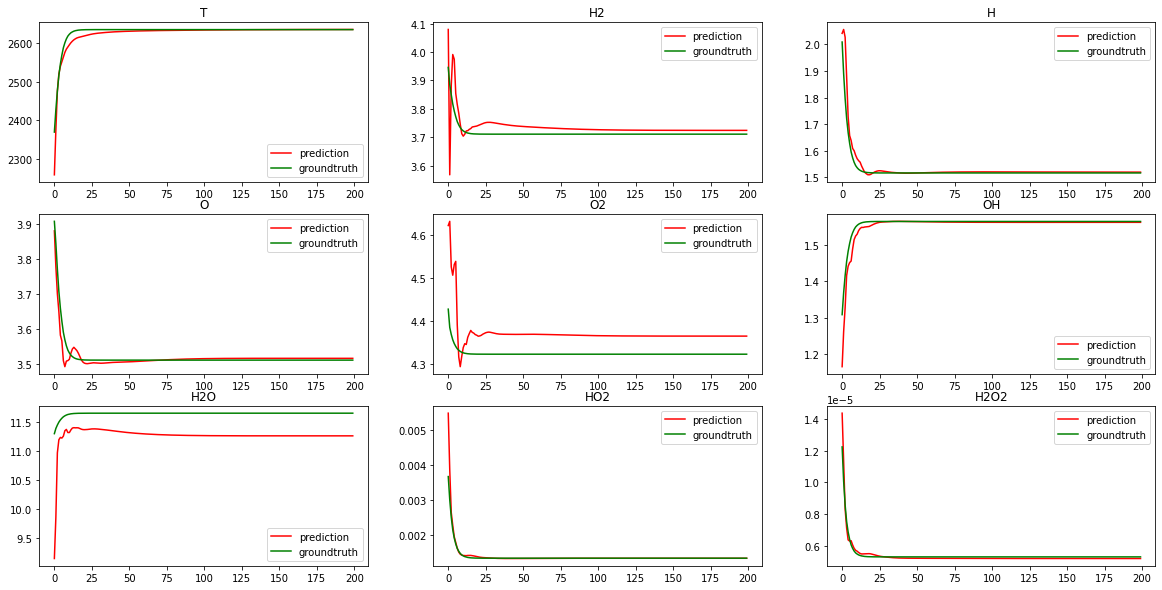

In [38]:
show_plots(torch.concat(predict_stack), torch.concat(target_stack), 138)

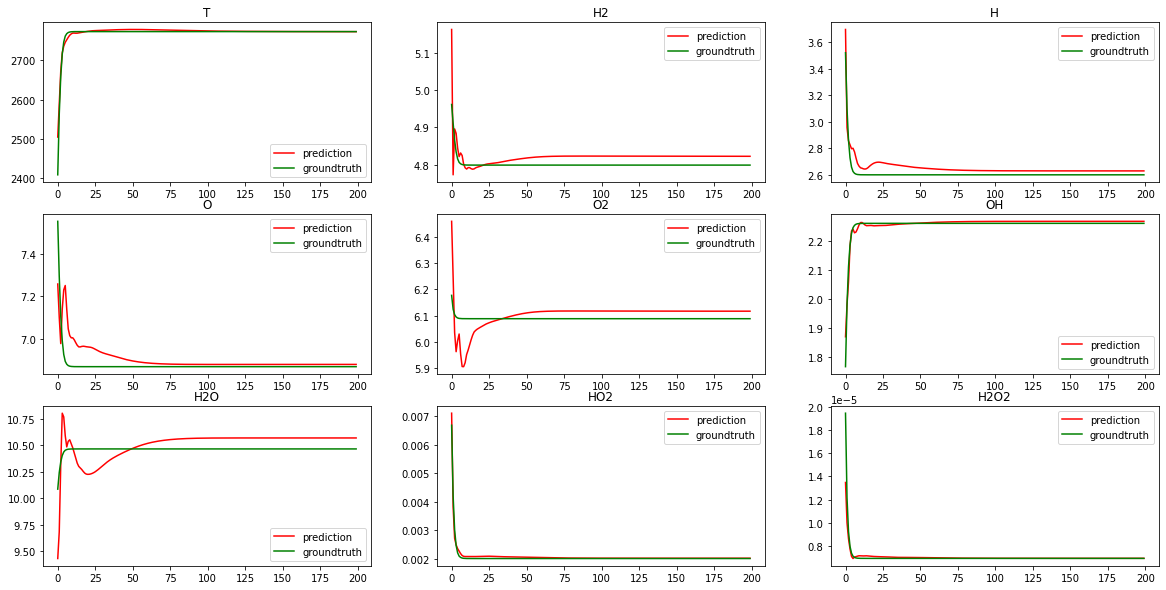

In [46]:
show_plots(torch.concat(predict_stack), torch.concat(target_stack),9)

### Inference on external **data**

In [42]:
input = torch.tensor([[[0.258059, 0.076098, 0.079991, 0.406154, 0.050154, 0.129445, 0.000035, 0.000065, 552392, 2869]]])
target =  torch.from_numpy(np.loadtxt('./Out_files_197/out0.txt', delimiter= ';')[1:, 1:-2])

pred, target = prediction(input, target, config)
error = torch.linalg.norm(target - pred)/torch.linalg.norm(target)
print('Error = ', error.item())

Error =  0.018332548627257576


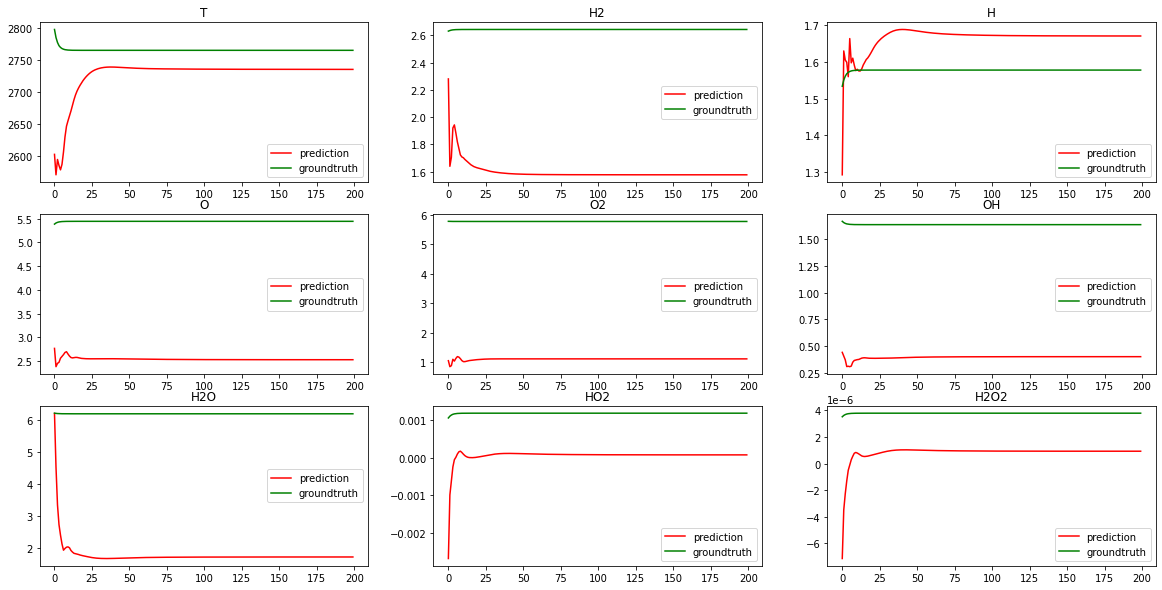

In [43]:
show_plots(pred, target)

In [44]:
input = torch.tensor([[[0.370668, 0.052756, 0.090097, 0.106036, 0.036734, 0.343536, 0.000104, 0.000068, 834259, 2874]]])
target =  torch.from_numpy(np.loadtxt('./Out_files_197/out10.txt', delimiter= ';')[1:, 1:-2])

pred, target = prediction(input, target, config)
error = torch.linalg.norm(target - pred)/torch.linalg.norm(target)
print('Error =', error.item())

Error = 0.03297676706664865


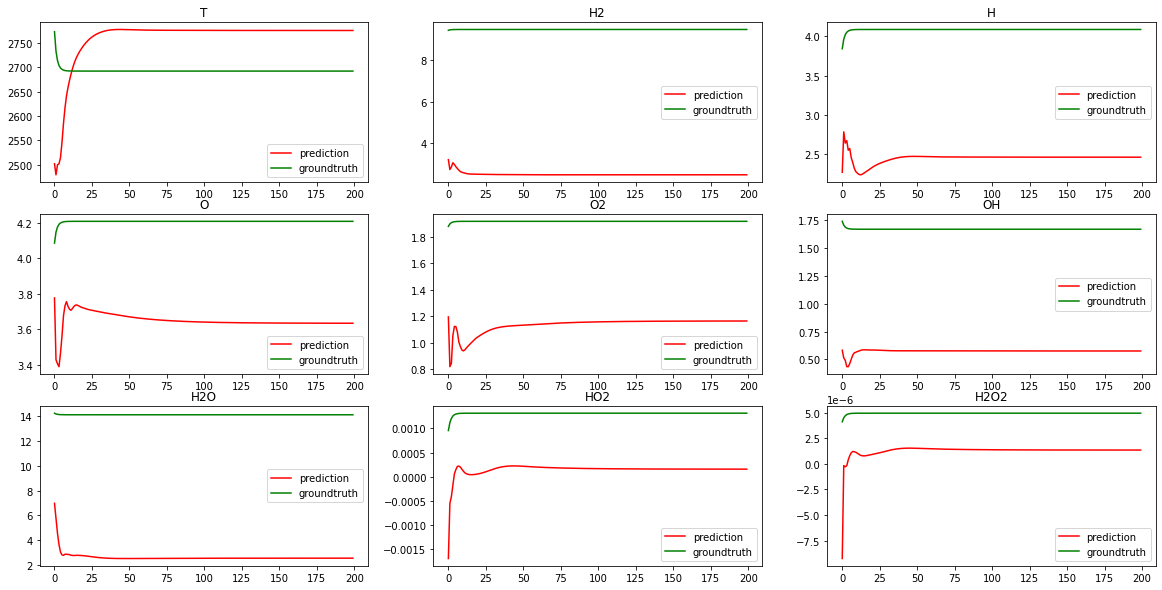

In [45]:
show_plots(pred, target)

#Comparing performance with model trained on all independent features

In [28]:
#load predictions of the other model
pred2 = torch.from_numpy(np.load('pred_test.npy'))

if config['exclude']:
  #reordering features to match
  C_H2_ = pred2[:, :, 1]
  C_O2_ = pred2[:, :, 4]
  ##Exclude O2 and H2
  pred2_ = np.delete(pred2, [1,4], axis = 2)
  ## Concatenate H2 and O2
  pred2 = torch.concat((pred2_, C_H2_.unsqueeze(dim = 2), C_O2_.unsqueeze(dim = 2)), dim = 2)
  
if config['return_conc']:
  pred2 = pred2[ :,1:,:]
  
pred2.shape

torch.Size([1, 200, 9])

In [31]:
def show_plots_3(predict1, predict2, target, lastH2O2= False):
  fig, ax = plt.subplots(3,3, figsize = (20,10))
  if lastH2O2:
    labels = ["T",	'H', 'O',	'OH',	'H2O',	'HO2',	'H2O2', 'H2', 'O2']
  else:
    labels = ["T",	'H2', 'H', 'O', 'O2', 'OH',	'H2O',	'HO2',	'H2O2']

  for i in range(9):
    a,b = i//3, i%3
    A = predict1[0,:,i]
    A_ = predict2[0, :, i]
    A_true = target[0,:,i]
    # ax[a,b].figure()
    ax[a,b].plot(A.detach().cpu(), '-r', label = 'Current Model')
    ax[a,b].plot(A_.detach().cpu(), '-b', label = 'All independents')
    ax[a,b].plot(A_true.detach().cpu(), '-g', label = 'groundtruth')
    ax[a,b].set_title(labels[i])
    ax[a,b].legend()
  plt.show()

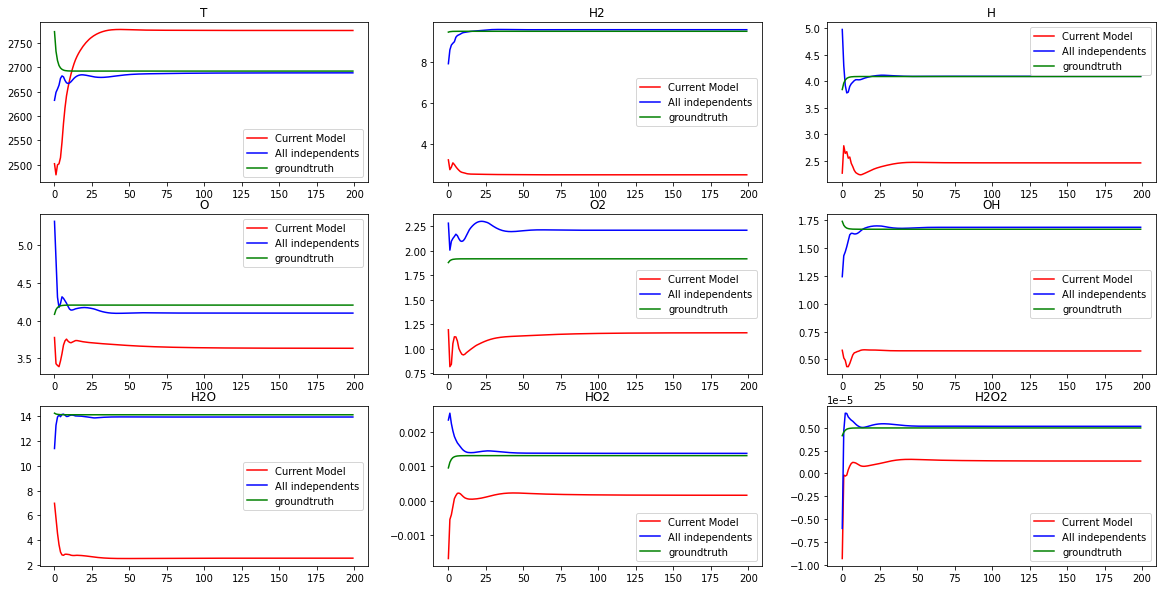

In [32]:
show_plots_3(pred, pred2, target)